# Quantum Singular Value Transformation (QSVT) 

In this work we will explore the Quantum Singular Value Transformation (QSVT), a framework that unifies many prominent quantum algorithms. 

## Quantum Signal Processing

For pedagogical purposes, we would like to start the discussion of QSVT with Quantum Singular Processing (QSP). Following Martyn et al. [1], we will implement two 
quantum circuits. The first one computes the Chebyshev polynomial of the first kind of a real number $a$, while the second one we can realize the BB1 pulse sequence. 


In [1]:
# import libraries 
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from scipy.special import chebyt
from matplotlib import pyplot as plt
import pyqsp

In [2]:
# signal rotation operator 
def W(a): 
    '''
    Return the signal rotation operator
    Arguments: 
        a: the parameter of the signal rotation operator, i.e theta = -2acos(a)
    Returns: 
        W: numpy array with the signal rotation operator
    '''
    return np.array([[a, 1j*np.sqrt(1-a**2)], [1j*np.sqrt(1-a**2), a]])

# Quantum signal processing circuit
def create_QSP_circuit(a,phi):
    '''
    Create a QSP circuit with parameters a and phi. 
    Arguments: 
        a  : rotation angle of the signal rotation operator.
        phi: numpy array with the rotation phases
    Returns: 
        qc :  a quantum circuit which implements the QSP 
    '''
    q = QuantumRegister(1)
    qc = QuantumCircuit(q)
    # add the phi0 signal-processing rotation 
    qc.rz(phi[0],q)
    # add the QSP rotations
    for i in range(1,phi.size):
        qc.unitary(W(a),q, label='W')
        qc.rz(-2*phi[i],q)
    return qc


### Chebyshev polynomial with QSP 

Here, we calculate the Chebyshev polynomial of the first kind of order $n$ of a real number $a$. We should note that, in a real Quantum Computer, we don't have 
direct access to the calculated value, since it is encoded as a probability amplitude. So, in a sense, we "cheat" a little bit here. 

In [3]:
# create the backend, it will be used to run all the circuits
backend = Aer.get_backend('statevector_simulator')

# create the circuit 
a = 0.33 # the real number a, for which we want to calculate the Chebyshev polynomial
N = 2 ; # order of the Chebyshev polynomial
phi = np.zeros(N+1) # 
print('a = ', a)
print('order of the Chebyshev polynomial: ', N)

qc = create_QSP_circuit(a,phi)


# run the circuit and get the output statevector
job = backend.run(qc)
result = job.result()
output_state = result.get_statevector(qc)
calculated_chebyt = output_state.data[0]

# calculate the Chebyshev polynomial 
chebyt_builtin = chebyt(N)(a)

# print the results
print('Built-in Chebyshev polynomial value: ', chebyt_builtin)
print('Calculated Chebyshev polynomial value: ', calculated_chebyt)


a =  0.33
order of the Chebyshev polynomial:  2
Built-in Chebyshev polynomial value:  -0.7822
Calculated Chebyshev polynomial value:  (-0.7822+0j)


### BB1 Pulse

We reproduce the Figure 1 of [1], which shows the BB1 pulse sequence.

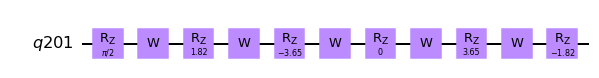

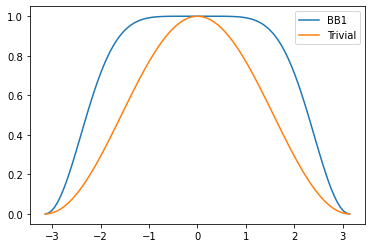

In [4]:
eta = 1/2 * np.arccos(-1/4)
phi = np.array([np.pi/2,-eta, 2*eta,0,-2*eta,eta])
theta = np.linspace(-np.pi,np.pi,100)
p = np.zeros(theta.size)
s = np.zeros(theta.size)

for i in range(theta.size):
    qc = create_QSP_circuit(np.cos(-theta[i]/2),phi)
    job = backend.run(qc)
    result = job.result()
    output_state = result.get_statevector(qc)
    p[i]= np.abs(output_state.data[0])**2
    qc = create_QSP_circuit(np.cos(-theta[i]/2),np.array([0,0]))
    job = backend.run(qc)
    result = job.result()
    output_state = result.get_statevector(qc)
    s[i]= np.abs(output_state.data[0])**2

# plot the probability with respect to theta
#p_theoretical = 1/8 * np.cos(theta/2)**2 *[3*np.cos(theta/2)**8 - 15*np.cos(theta/2)**6 + 35*np.cos(theta/2)**4 - 45*np.cos(theta/2)**2 + 30]
plt.plot(theta,p, label = 'BB1')
plt.plot(theta,s, label = 'Trivial')
plt.legend()

# plot the quantum signal processing circuit, for theta = -pi 
qc = create_QSP_circuit(np.cos(-theta[0]/2),phi)
qc.draw(output = 'mpl')


## Search by QSVT

We will now use the QSVT to implement a search algorithm. Some remarks: 
1. The unitary matrix we wish to block encode is the $H^{\otimes n}$, where $H$ is the Hadamard gate. In the paper they block encode the identity matrix, assuming that 
the initial state is the uniform superposition. Here, we assume that the initial state is the zero state and we block encode the $H^{\otimes n}$ matrix. 
2. In order to apply the projector controlled phase shift, we used the fact that $e^{i(2P-1)x} = cos(x) + (2P-I)sin(x)$, where $P$ is the projector. This is relation 
can be easily proved by using the euler formula for the exponential function, expanding the sine and cosine functions as a power series and using the fact that $P^2 = P$.
3. The phases for the sign approximation are calculated using the python library pyqsp. 
4. In general, in a search algorithm, we assume that we have an oracle that marks the solution. Using that oracle, we can implement the projector controlled phase shift to the marked state, even if we don't know the marked state. In our case, we just chose a random marked state and defined the projector that projects onto that state. This is not what we would do in a real search algorithm, but we assumed it here for simplicity. 


Possible improvements:
1) Apply the projector controlled phase shift using an ancilla qubit and a projection. How the projection is actually implemented in a real quantum computer? Is it a generalized measurement?
2) Use an oracle that marks a particular state.

In [5]:
def p_controlled_phase_shift(P, phi):
    '''
    Return the projector-controlled phase shift operator
    '''
    N = len(P)
    return np.eye(N)*np.cos(phi)+1j*(2*P-np.eye(N))*np.sin(phi)


def create_qsvt_circuit(U,PL,PR, phi, num_qubits):

    '''
    Create a QSVT circuit with parameters U, PL, PR and phi. 
    Arguments: 
        U  : the unitary operator, which block encodes the matrix of interest
        PL : the left projector
        PR : the right projector
        phi: numpy array with the rotation phases
    Returns: 
        qc :  a quantum circuit which implements the QSVT 
    '''
    # create the quantum circuit
    q = QuantumRegister(num_qubits)
    qc = QuantumCircuit(q)


    N = len(phi)
    d = N - 1
    if len(phi)%2 != 0:
        # if the number of phases is odd, then the polynomial is of even degree, Pr = Pi and Pl = Pi_tilde
        qc.unitary(p_controlled_phase_shift(PR,phi[-1]),q, label = (r'$\widetilde{\Pi}_{' + str(d)) + '}$')
        for i in reversed(range((d//2))):
            qc.unitary(U,q, label = (r'U'))
            qc.unitary(p_controlled_phase_shift(PL,phi[2*i+1]),q, label = (r'$\widetilde{\Pi}_{' + str(2*i+1)) + '}$')
            qc.unitary(U.T.conj(),q, label = (r'U$^\dagger$'))
            qc.unitary(p_controlled_phase_shift(PR,phi[2*i]),q, label = (r'$\widetilde{\Pi}_{' + str(2*i)) + '}$')
    else:
        # if the number of phases is even, then the polynomial is of odd degree
        qc.unitary(p_controlled_phase_shift(PR,phi[d]),q, label = (r'$\widetilde{\Pi}_{' + str(d)) + '}$') 
        for i in reversed(range(1, (d-1)//2+1)):
            qc.unitary(U,q, label = (r'U'))        
            qc.unitary(p_controlled_phase_shift(PL,phi[2*i]),q, label = (r'$\widetilde{\Pi}_{' + str(2*i)) + '}$')
            qc.unitary(U.T.conj(),q, label = (r'U$^\dagger$'))
            qc.unitary(p_controlled_phase_shift(PR,phi[2*i-1]),q, label = (r'$\widetilde{\Pi}_{' + str(2*i-1)) + '}$')
        qc.unitary(U,q, label = (r'U'))
        qc.unitary(p_controlled_phase_shift(PL,phi[0]),q, label = (r'$\widetilde{\Pi}_{' + str(0)) + '}$')
    return qc

def angles_from_W_to_R(phis):
    """Converts QSP angles from W-convention to R-convention."""
    # see page 27 of grand unification paper
    phis = [phis[0]+(2*(len(phis)-1)-1)*np.pi/4] + [phi-np.pi/2 for phi in phis[1:-1]] + [phis[-1]-np.pi/4]
    return phis 

def sign_approximating_polynomial(num_qubits):
    """Polynomial that approximates the step function theta(x) for x>= 1/N**0.5"""
    
    N = 2**num_qubits
    target_function = pyqsp.poly.PolySign()
    # we take the closest odd number to N**0.5. 
    degree = np.ceil(N**0.5) + (degree % 2 == 0)
        
    # this is connected to the width of our approximation
    Delta = N**0.5
    
    # Find the polynomial approximation.
    p = target_function.generate(degree, delta=Delta)
    
    return p

### Polynomial approximation

We show some approximations of the sign function using polynomials of different degrees. We can see that the approximation gets better as the degree of the polynomial increases.

[pyqsp.poly.PolySign] degree=3, delta=2.0
[PolyTaylorSeries] max [0.88487764] is at [0.89510929]: normalizing
[PolyTaylorSeries] average error = 0.12112171443398506 in the domain [-1, 1] using degree 3
[pyqsp.poly.PolySign] degree=3, delta=2.8284271247461903
[PolyTaylorSeries] max [0.86327883] is at [0.86147542]: normalizing
[PolyTaylorSeries] average error = 0.19244082131510504 in the domain [-1, 1] using degree 3
[pyqsp.poly.PolySign] degree=5, delta=4.0
[PolyTaylorSeries] max [0.90000001] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.13772714862145935 in the domain [-1, 1] using degree 5
[pyqsp.poly.PolySign] degree=7, delta=5.656854249492381
[PolyTaylorSeries] max [0.89508306] is at [0.96694539]: normalizing
[PolyTaylorSeries] average error = 0.138576375175681 in the domain [-1, 1] using degree 7
[pyqsp.poly.PolySign] degree=9, delta=8.0
[PolyTaylorSeries] max [0.9] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.13632827412557 in the domain [-1, 1] usin

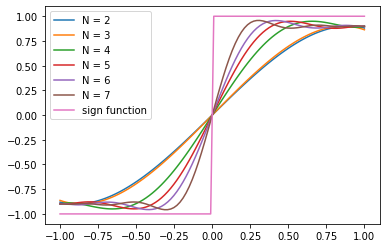

In [6]:
# check the polynomial approximation for different values of qubits 
N = np.arange(2,8)
for n in N:
    p = sign_approximating_polynomial(n)
    x = np.linspace(-1,1,100)
    plt.plot(x,p(x), label = 'N = '+str(n))

# plot the sign function
plt.plot(x,np.sign(x), label = 'sign function')
plt.legend()



Here we implement the actual search algorithm. We notice that using that circuit amplifies the probability of measuring the marked state, according to the approximation of sign function, i.e the probability amplitute after applying the circuit is equal to the value of the approximating polynomial. 

In [7]:
from functools import reduce
from pyqsp import angle_sequence

np.random.seed(42)
qubits = 4; 

# apply the hadamard gate to all qubits
H = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
U = reduce(np.kron, [H]*qubits)

# Create the qsvt circuit

# define the left projector
all_zero_state = np.zeros(2**qubits) ; all_zero_state[0] = 1
PR = np.outer(all_zero_state,all_zero_state.conj())
# define the right projector
r = np.random.randint(0,2**qubits)
m = np.zeros(2**qubits) ; m[r] = 1
PL = np.outer(m,m.conj())

# Estimate the phases 
p = sign_approximating_polynomial(qubits)
phi = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p.coef, signal_operator='Wx')
phi = angles_from_W_to_R(phi)

# create the circuit
backend = Aer.get_backend('statevector_simulator')
qsvt_circuit = create_qsvt_circuit(U,PL,PR, phi, qubits)

# run the circuit and get the output statevector
job = backend.run(qsvt_circuit)
result = job.result()
output_state = np.array(result.get_statevector(qsvt_circuit))

# find the probability of measuring the |m> state
initial_prob_ampl = 1/np.sqrt(2**qubits)

# find the overlap between the output state and the |m> state
prob_ampl = output_state[r]

# print the results
print('Initial probability amplitude: ', initial_prob_ampl)
print('Approximating polynomial value: ', sign_approximating_polynomial(qubits)(2**(-0.5*qubits)))
print('Probability amplitude after QSVT: ', prob_ampl)


[pyqsp.poly.PolySign] degree=5, delta=4.0
[PolyTaylorSeries] max [0.90000001] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.13772714862145935 in the domain [-1, 1] using degree 5
Initial probability amplitude:  0.25
[pyqsp.poly.PolySign] degree=5, delta=4.0
[PolyTaylorSeries] max [0.90000001] is at [1.]: normalizing
[PolyTaylorSeries] average error = 0.13772714862145935 in the domain [-1, 1] using degree 5
Approximating polynomial value:  0.5591529553315698
Probability amplitude after QSVT:  (0.5590970888592798+0.20579316989997803j)


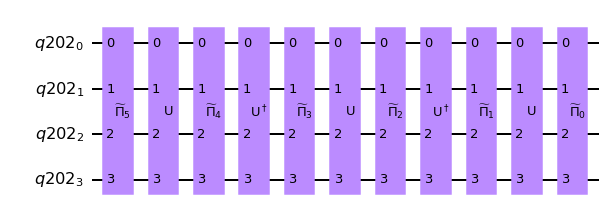

In [8]:
# draw the circuit
qsvt_circuit.draw(output = 'mpl')

## Solving Linear Systems of Equations

## Hamiltonian Simulation

## Quantum Phase Estimation

## Literature
[1] J. M. Martyn, Z. M. Rossi, A. K. Tan, and I. L. Chuang, A Grand Unification of Quantum Algorithms, PRX Quantum 2, (2021).

[2] A. Gilyén, Y. Su, G. H. Low, and N. Wiebe, Quantum singular value transformation and beyond: Exponential improvements for quantum matrix arithmetics, Proceedings of the Annual ACM Symposium on Theory of Computing 193 (2019).

[3] A. Gilyén, Quantum Singular Value Transformation& Its Algorithmic Applications, (2019).

[4] I. Chuang and et al, Pyqsp: Quantum Signal Processing, (2022).

[5] Introduction to Quantum Singular Value Transformation, https://idnm.github.io/blog/posts/quantum_singular_value_transformation_intro/
